In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import torch

from resalloc.fungible import AllocationProblem
from resalloc.fungible import utilities

from latexify import latexify
latexify()

In [2]:
def make_problem(n_jobs, n_resources, device):

    resource_limits = torch.rand(n_resources, device=device) * n_jobs + 1e3
    job_demands = None
    utility_fn = utilities.Log()
    
    max_tries = 50
    tries = 0
        
    throughput_matrix = torch.tensor(
        np.random.uniform(low=1., high=2., size=(n_jobs, n_resources))
    ).float()
    throughput_matrix = throughput_matrix.to(device)

    problem = AllocationProblem(
        throughput_matrix,
        resource_limits=resource_limits,
        job_demands=job_demands,
        utility_function=utility_fn
    )
    return problem

In [3]:
from collections import namedtuple

Stats = namedtuple('Stats', ['mean', 'std', 'min', 'max'])

In [4]:
from tqdm.auto import tqdm
import time

resources = torch.tensor(np.linspace(start=2, stop=100, num=10)).int()
jobs = [int(1e5)]*len(resources)
n_trials = 5

def benchmark(device, jobs, resources, n_trials):
    device_times = []
    for j, r in tqdm(list(zip(jobs, resources))):
        print(f'{r} RESOURCES')

        torch.manual_seed(0)
        np.random.seed(0)

        times = []
        for i in tqdm(range(n_trials)):
            problem = make_problem(j, r, device)
            prices = problem.utility_fn.initial_prices(problem)
            start = time.time()
            #_, stats = problem.solve(eps=eps, max_iter=max_iter, print_every=1, verbose=False)
            problem.evaluate_dual_function(prices)
            if device == 'cuda':
                torch.cuda.synchronize()
            end = time.time()
            del problem
            times.append(end - start)
        times = np.array(times)
        mean = np.mean(times)
        std = np.std(times)
        min_ = np.min(times)
        max_ = np.max(times)
        device_times.append(Stats(mean, std, min_, max_))
    return device_times


In [5]:
#gpu_stats = benchmark('cuda', jobs, resources, n_trials)

In [6]:
cpu_stats = benchmark('cpu', jobs, resources, n_trials)

  0%|          | 0/10 [00:00<?, ?it/s]

2 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

12 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

23 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

34 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

45 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

56 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

67 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

78 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

89 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

100 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
jobs_j = list(map(int, [1e2, 1e3, 1e4, 1e5, 1e6, 1e7]))
resources_j = [4]*len(jobs_j)

In [8]:
#gpu_stats_j = benchmark('cuda', jobs_j, resources_j, n_trials)
cpu_stats_j = benchmark('cpu', jobs_j, resources_j, n_trials)

  0%|          | 0/6 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

4 RESOURCES


  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
gpu_t = np.load('output/gpu_t.npy')
gpu_err = np.load('output/gpu_err.npy')
gpu_t_j = np.load('output/gpu_t_j.npy')
gpu_err_j = np.load('output/gpu_err_j.npy')

In [10]:
print(cpu_stats_j[2].mean)

0.002837371826171875


In [52]:
import cvxpy as cp

def times_errs(stats):
    times = np.array([s.mean for s in stats])
    up_err = [s.max - s.mean for s in stats]
    down_err = [s.mean - s.min for s in stats]
    yerr = np.array([up_err, down_err])
    return times, yerr

cpu_t, cpu_err = times_errs(cpu_stats)
cpu_t_j, cpu_err_j = times_errs(cpu_stats_j)

a = cp.Variable()
b = cp.Variable()

start = 1
targets = np.log(cpu_t)
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(resources[start:])))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

cpu_t_inputs = np.linspace(resources[start], 100, 100)
cpu_t_quad_fit = np.exp((a.value + b.value*(np.log(cpu_t_inputs))))
cpu_t_quad_fit

a = cp.Variable()
b = cp.Variable()

targets = np.log(gpu_t)
start = 1
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(resources[start:].cpu().numpy())))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

gpu_t_inputs = np.linspace(resources[start], resources[-1], 100)
gpu_t_fit = np.exp(a.value + b.value*(np.log(gpu_t_inputs)))
gpu_t_fit


a = cp.Variable()
b = cp.Variable()

targets = np.log(cpu_t_j)
start = 2
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(np.array(jobs_j[start:]))))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

cpu_t_j_inputs = np.linspace(jobs_j[start], jobs_j[-1], 100)
cpu_t_j_fit = np.exp((a.value + b.value*(np.log(cpu_t_j_inputs))))
cpu_t_j_fit

a = cp.Variable()
b = cp.Variable()

start = 3
targets = np.log(gpu_t_j)
residuals = cp.sum_squares(targets[start:] - (a + b*np.log(np.array(jobs_j[start:]))))
problem = cp.Problem(cp.Minimize(residuals))
problem.solve()

print(np.exp(a.value))
print(b.value)

gpu_t_j_inputs = np.linspace(jobs_j[start], jobs_j[-1], 100)
gpu_t_j_fit = np.exp(a.value + b.value*(np.log(gpu_t_j_inputs)))
gpu_t_j_fit


0.0014499234446240462
2.0313552904695404
6.74958287516051e-05
1.748695236968488
1.6170273979732102e-07
1.051487265122501
1.7333945162643855e-07
0.8144489170947226


array([0.00204711, 0.00360011, 0.00500879, 0.00633124, 0.00759307,
       0.00880859, 0.00998691, 0.01113429, 0.0122553 , 0.01335337,
       0.01443122, 0.01549102, 0.01653453, 0.01756324, 0.0185784 ,
       0.01958106, 0.02057216, 0.02155248, 0.02252275, 0.02348359,
       0.02443555, 0.02537913, 0.02631478, 0.02724291, 0.0281639 ,
       0.02907807, 0.02998573, 0.03088718, 0.03178268, 0.03267246,
       0.03355675, 0.03443577, 0.0353097 , 0.03617873, 0.03704303,
       0.03790276, 0.03875808, 0.03960911, 0.04045599, 0.04129886,
       0.04213782, 0.042973  , 0.04380449, 0.0446324 , 0.04545683,
       0.04627787, 0.0470956 , 0.0479101 , 0.04872147, 0.04952977,
       0.05033507, 0.05113745, 0.05193697, 0.0527337 , 0.05352769,
       0.05431901, 0.05510771, 0.05589385, 0.05667748, 0.05745864,
       0.0582374 , 0.05901379, 0.05978785, 0.06055965, 0.0613292 ,
       0.06209657, 0.06286178, 0.06362487, 0.06438588, 0.06514485,
       0.06590181, 0.0666568 , 0.06740984, 0.06816097, 0.06891

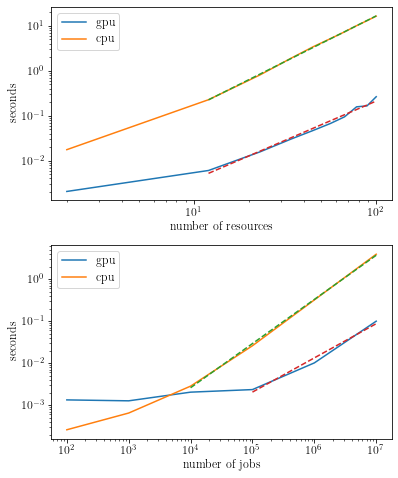

In [46]:
fig, axs = plt.subplots(2, 1, figsize=(5.7, 6.8))

axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].plot(resources, gpu_t, label='gpu')
axs[0].plot(resources, cpu_t, label='cpu')
axs[0].plot(cpu_t_inputs, cpu_t_quad_fit, linestyle='--')
axs[0].plot(gpu_t_inputs, gpu_t_fit, linestyle='--')
axs[0].set_xlabel('number of resources')
axs[0].set_ylabel('seconds')
axs[0].legend()

axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot(jobs_j, gpu_t_j, label='gpu')
axs[1].plot(jobs_j, cpu_t_j, label='cpu')
axs[1].plot(cpu_t_j_inputs, cpu_t_j_fit, linestyle='--')
axs[1].plot(gpu_t_j_inputs, gpu_t_j_fit, linestyle='--')
axs[1].set_xlabel('number of jobs')
axs[1].set_ylabel('seconds')
axs[1].legend()
plt.tight_layout()
plt.savefig('scaling.pdf')

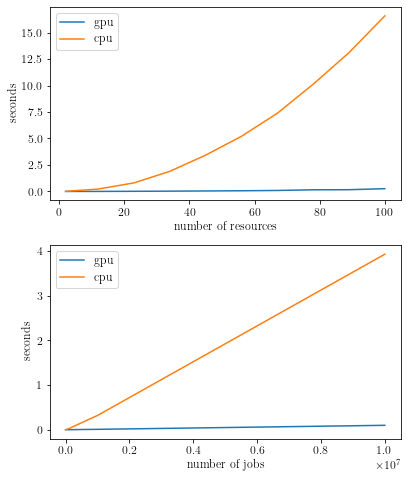

In [51]:
fig, axs = plt.subplots(2, 1, figsize=(5.7, 6.8))

axs[0].plot(resources, gpu_t, label='gpu')
axs[0].plot(resources, cpu_t, label='cpu')
axs[0].set_xlabel('number of resources')
axs[0].set_ylabel('seconds')
axs[0].legend()

axs[1].plot(jobs_j, gpu_t_j, label='gpu')
axs[1].plot(jobs_j, cpu_t_j, label='cpu')
axs[1].set_xlabel('number of jobs')
axs[1].set_ylabel('seconds')
axs[1].legend()
plt.tight_layout()

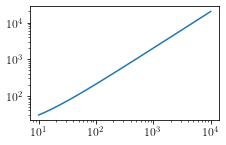

In [137]:
x = np.logspace(1, 4, 100)
y = 2*x**1 + 10

plt.plot(x, y)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [10]:
times = np.array([s.mean for s in cpu_times])
up_err = [s.max - s.mean for s in cpu_times]
down_err = [s.mean - s.min for s in cpu_times]
yerr = np.array([up_err, down_err])
plt.figure(figsize=(5.7, 4))
plt.errorbar(resources, times, yerr=yerr)
plt.xlabel('number of resources')
plt.ylabel('seconds')

NameError: name 'cpu_times' is not defined

In [3]:
torch.manual_seed(0)
np.random.seed(0)
targets = torch.tensor([0.25]*n_jobs, device=device).reshape(-1, 1)

priorities = torch.randint(low=1, high=3, size=(n_jobs, 1), device=device)

if USE_DOUBLES:
    targets = targets.double()
    priorities = priorities.double()

target_utility_fn = utilities.TargetPriority(targets, priorities)

priority_problem = AllocationProblem(
    throughput_matrix,
    resource_limits=resource_limits,
    utility_function=target_utility_fn,
)

In [4]:
p_prices, p_stats = priority_problem.solve(eps=1e-3, snapshot_every=1, verbose=True)
print(f'Solve took {p_stats.solve_time:.3e} seconds')
print('optimal value ', p_stats.utils[-1])
print('upper bound', p_stats.dual_values[-1])
p_prices

# From MOSEK below ...
P_OPT_VALUE = -38946.1010989067 / n_jobs
P_OPT_PRICES = np.array([0.12113543, 0.37165886, 1.02147318, 1.7266437])

Mar 26 11:37:30 AM: iteration 00 | utility=-0.119563 | dual_value=0.0018908 | gap=1.21e-01
Mar 26 11:37:30 AM: iteration 05 | utility=-0.0577112 | dual_value=-0.017768 | gap=3.99e-02
Mar 26 11:37:31 AM: iteration 10 | utility=-0.0446213 | dual_value=-0.0387265 | gap=5.89e-03
Mar 26 11:37:31 AM: Converged in 013 iterations, with residual 0.000639719
Solve took 6.059e-01 seconds
optimal value  -0.03952421875
upper bound -0.0388845


In [6]:
p_X_opt = priority_problem.make_feasible(priority_problem.X)
print('fraction jobs with slack ', (p_X_opt[:, 0] > 0).sum().item() / float(n_jobs))
((p_X_opt[:, 1:] > 1e-6).sum(axis=1) == 2).sum() / n_jobs

fraction jobs with slack  0.359061


tensor(0.2535, device='cuda:0')

In [7]:
prices, stats = alloc_problem.solve(eps=1e-3, snapshot_every=1, verbose=True)
print(f'Solve took {stats.solve_time:.3e} seconds')
print('optimal value ', stats.utils[-1])
print('upper bound', stats.dual_values[-1])
prices

Mar 26 11:37:38 AM: iteration 00 | utility=-1.73708 | dual_value=-1.4098 | gap=3.27e-01
Mar 26 11:37:38 AM: iteration 05 | utility=-1.53582 | dual_value=-1.51522 | gap=2.06e-02
Mar 26 11:37:38 AM: iteration 10 | utility=-1.52336 | dual_value=-1.52179 | gap=1.56e-03
Mar 26 11:37:38 AM: Converged in 012 iterations, with residual 8.9e-05
Solve took 2.946e-01 seconds
optimal value  -1.52191825
upper bound -1.52182925


tensor([0.0000, 0.7018, 1.7535, 3.9067, 6.1830], device='cuda:0')

In [8]:
X_opt = alloc_problem.make_feasible(alloc_problem.X)
print('fraction jobs with slack ', (X_opt[:, 0] > 0).sum().item() / float(n_jobs))

fraction jobs with slack  0.183328


In [9]:
((X_opt[:, 1:] > 1e-6).sum(axis=1) == 2).sum() / n_jobs

tensor(0.1701, device='cuda:0')

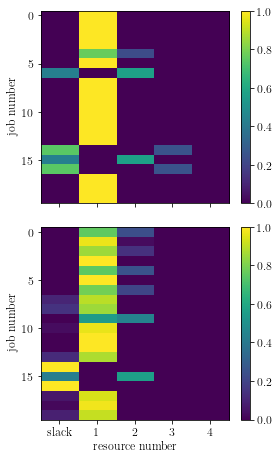

In [13]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((4.5/1.1, 7.2/1.1))

def plot_X(X, n_jobs=20, ax=None):
    sparsity_pattern = (X > 0).cpu().numpy()
    sparsity_pattern = sparsity_pattern * 1.

    if ax is None:
        fig = plt.figure()
        fig.set_size_inches(7, 8)
        ax = plt.gca()
    im = ax.imshow(X[:n_jobs].cpu().numpy(), aspect='auto', cmap='viridis')
    plt.colorbar(im, ax=ax)
    ax.set_xticks([0, 1, 2, 3, 4])
    ax.set_xticklabels(['slack', 1, 2, 3, 4])
    ax.set_ylabel('job number')
    ax.set_yticks([0, 5, 10, 15])
    return im

im = plot_X(X_opt, ax=axs[0])
plot_X(p_X_opt, ax=axs[1])
axs[1].set_xlabel('resource number')
plt.tight_layout()
plt.savefig('allocation_matrices.pdf')

In [ ]:
fig = plt.figure()
fig.set_size_inches(6.4, 3.)
plt.imshow(X_opt.cpu(), aspect='auto')
plt.xlabel('resource')
plt.ylabel('job')
plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xticks([0, 1, 2, 3, 4])
plt.gca().set_xticklabels(['slack', 1, 2, 3, 4])
plt.colorbar()
plt.tight_layout()
plt.savefig('allocation_matrix.pdf')

In [ ]:
plt.figure(figsize=(5.7, 2.4))
plt.hist(stats.throughputs[0].cpu(), color='tab:blue', bins=500, label='initial', alpha=0.3)
plt.hist(stats.throughputs[-1].cpu(), color='tab:orange', bins=500, label='final', alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('number of jobs')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('throughput_distributions.pdf')

In [15]:
def _cdf(array, n_bins=None, ax=None, xlabel=None, label=None, color=None):
    array = np.sort(array)                                                       
    if n_bins is None:                                                           
        n_bins = min(array.size, 100000)                                         
    step = int(array.size / n_bins)                                              
    bins = np.arange(1, array.size + 1, step=step)                               
    if bins[-1] != array.size:                                                   
        bins = np.concatenate((bins, np.array([array.size])))                    
    heights = bins / float(array.size)                                           
                                                                                 
    if ax is None:
        ax = plt.gca()                                                               
    ax.step(array[bins - 1], heights, color=color, label=label)
    if xlabel is not None:
        ax.set_xlabel(xlabel)

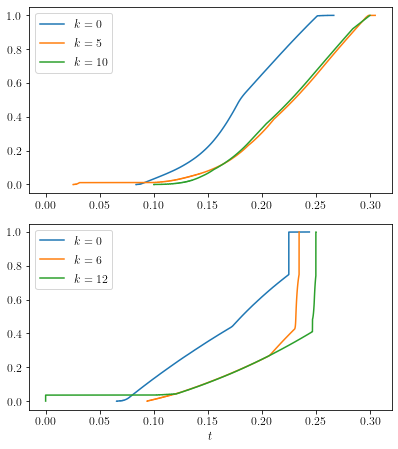

In [17]:
#plt.hist(throughputs[0], color='tab:blue', bins=500, label='initial', alpha=0.3)
#plt.hist(throughputs[-1], color='tab:orange', bins=500, label='final', alpha=0.3)
#plt.hist(throughputs[-1], color='tab:orange', bins=500, label='final', alpha=0.3)
fig, axs = plt.subplots(2, 1, sharex=True)
fig.set_size_inches((5.7, 6.4))

def plot_cdfs(throughputs, iters, ax, colors=None):
    for i in iters:
        _cdf(throughputs[i].cpu(), n_bins=5000, ax=ax, label=f'$k={i}$')
        
plot_cdfs(stats.throughputs, [0, 5, 10], axs[0])
plot_cdfs(p_stats.throughputs, [0, 6, 12], axs[1])
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel('$t$')

for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

plt.tight_layout()
plt.savefig('throughput_distributions.pdf')

In [19]:
# from MOSEK solve below ...
OPT_VALUE = -1521835.4311374626 / n_jobs
OPT_PRICES = np.array([0.70200379, 1.75420888, 3.90780805, 6.19478944])
#tensor([1.0089, 1.5876, 2.9808, 4.3457], dtype=torch.float64)

prices  tensor([0.0000, 0.7051, 1.7601, 3.9182, 6.1505])
prices  tensor([0.0000, 0.1200, 0.3612, 1.0540, 1.7186])


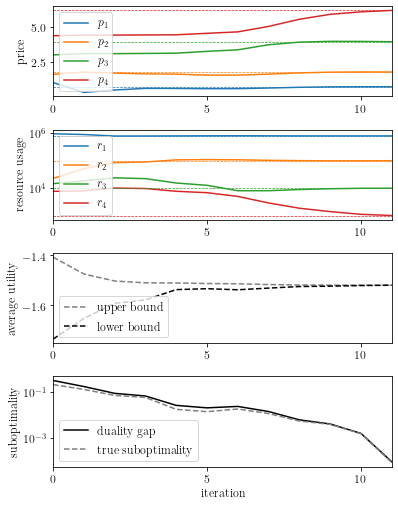

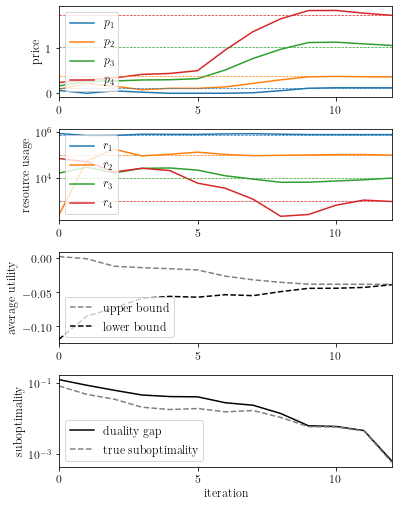

In [23]:
def plot_four(alloc_problem, stats, opt_prices, opt_value, xticks, figname=None):
    fig, axs = plt.subplots(4, 1)
    fig.set_size_inches((5.7, 7.2))

    stop_at = np.argmax(np.array(stats.gaps) < 1e-3)
    price_history = torch.stack(stats.snapshots)
    axs[0].plot(price_history[:, 1].cpu().numpy(), label='$p_1$')
    axs[0].plot(price_history[:, 2].cpu().numpy(), label='$p_2$')
    axs[0].plot(price_history[:, 3].cpu().numpy(), label='$p_3$')
    axs[0].plot(price_history[:, 4].cpu().numpy(), label='$p_4$')
    axs[0].axhline(opt_prices[0], linestyle='--', color='tab:blue', linewidth=0.7)
    axs[0].axhline(opt_prices[1], linestyle='--', color='tab:orange', linewidth=0.7)
    axs[0].axhline(opt_prices[2], linestyle='--', color='tab:green', linewidth=0.7)
    axs[0].axhline(opt_prices[3], linestyle='--', color='tab:red', linewidth=0.7)
    axs[0].set_ylabel('price')
    axs[0].set_xticks(xticks)
    axs[0].set_xlim(0, len(stats.gaps) - 1)
    axs[0].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[0].legend(loc='upper left')

    resource_history = torch.stack(stats.resource_usage)[:, 1:].cpu().numpy()
    axs[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[1].plot(resource_history[:, 0], label='$r_1$')
    axs[1].plot(resource_history[:, 1], label='$r_2$')
    axs[1].plot(resource_history[:, 2], label='$r_3$')
    axs[1].plot(resource_history[:, 3], label='$r_4$')
    axs[1].axhline(alloc_problem.resource_limits[1], linestyle='--', color='tab:blue', linewidth=0.7)
    axs[1].axhline(alloc_problem.resource_limits[2], linestyle='--', color='tab:orange', linewidth=0.7)
    axs[1].axhline(alloc_problem.resource_limits[3], linestyle='--', color='tab:green', linewidth=0.7)
    axs[1].axhline(alloc_problem.resource_limits[4], linestyle='--', color='tab:red', linewidth=0.7)
    axs[1].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[1].set_ylabel('resource usage')
    axs[1].set_yscale('log')
    axs[1].legend(loc='upper left')
    axs[1].set_xticks(xticks)
    axs[1].set_xlim(0, len(stats.gaps) - 1)
#    axs[1].set_xlim(0, 11)

    axs[2].plot(np.array(stats.dual_values), color='gray', linestyle='--', label='upper bound')
    axs[2].plot(stats.utils, color='black', linestyle='--', label='lower bound')
    axs[2].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[2].set_ylabel('average utility')
    axs[2].legend(loc='lower left')
    axs[2].set_xticks(xticks)
    axs[2].set_xlim(0, len(stats.gaps) - 1)
#    axs[2].set_xlim(0, 11)

    axs[3].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    axs[3].plot((np.array(stats.dual_values) - np.array(stats.utils)), color='black', label='duality gap')
    axs[3].plot((opt_value - np.array(stats.utils)), color='gray', linestyle='--', label='true suboptimality')
    axs[3].set_ylabel('suboptimality')
    #axs[3].axhline(1e-3, linestyle='--', color='k', linewidth=0.5)
    axs[3].axvline(stop_at, linestyle='--', color='gray', linewidth=0.5)
    axs[3].set_yscale('log')
    axs[3].set_yticks([1e-1, 1e-3])
    axs[3].set_xticks(xticks)
    axs[3].legend(loc='lower left')
#    axs[3].set_xlim(0, 11)
    axs[3].set_xlim(0, len(stats.gaps) - 1)
    axs[3].set_xlabel('iteration')

    plt.tight_layout()
    #plt.savefig('synthetic_example_four_plots.pdf')
    if figname is not None:
        plt.savefig(figname)
    print('prices ', price_history[-1])
    

plot_four(alloc_problem, stats, OPT_PRICES, OPT_VALUE, [0, 5, 10], 'progress_log.pdf')
plot_four(priority_problem, p_stats, P_OPT_PRICES, P_OPT_VALUE, [0, 5, 10], 'progress_target.pdf')

In [53]:
dual_values

[-301528.4268487119,
 -340978.1875,
 -349380.46875,
 -351247.78125,
 -352311.75,
 -353030.125,
 -354470.15625,
 -354600.625,
 -354627.3125,
 -354628.0625,
 -354628.28125,
 -354628.28125]

In [37]:
price_history = torch.stack(stats.snapshots)
axs[0].plot(price_history[:, 1:].cpu().numpy())
axs[0].set_xlabel('iteration')
axs[0].set_ylabel('price')
#plt.legend()
#plt.tight_layout()
#plt.show()
print('prices ', price_history[-1])

prices  tensor([0.0000, 1.0618, 1.4872, 0.9622, 1.3176])


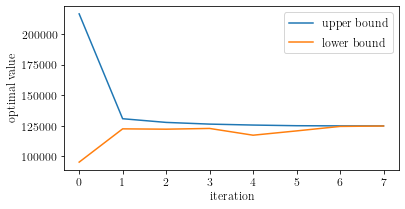

In [5]:
plt.figure(figsize=(6, 2))
plt.plot(dual_values, label='upper bound')
plt.plot(utilities, label='lower bound')
plt.xlabel('iteration')
plt.ylabel('optimal value')
plt.legend()

In [5]:
problem = allocator.make_cvxpy_problem()

In [6]:
#problem.solve(cp.SCS, max_iters=10, acceleration_lookback=0, verbose=True)
problem.solve(cp.MOSEK, verbose=True)
print(problem.objective.value)
print(problem.constraints[1].dual_value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Mar 24 02:20:19 PM: Your problem has 50000 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 24 02:20:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 24 02:20:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 24 02:20:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 24 02:20:19 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 24 02:20:19 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> 

(CVXPY) Mar 24 02:20:21 PM: Optimal value: -1.525e+00
(CVXPY) Mar 24 02:20:21 PM: Compilation took 1.356e-01 seconds
(CVXPY) Mar 24 02:20:21 PM: Solver (including time spent in interface) took 2.367e+00 seconds
-1.525487584429425
[6.99221189e-05 1.74909788e-04 3.97148776e-04 6.26997996e-04]


In [36]:
#problem.solve(cp.SCS, max_iters=10, acceleration_lookback=0, verbose=True)
problem.solve(cp.MOSEK, verbose=True)
print(problem.objective.value)
print(problem.constraints[1].dual_value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Mar 23 02:55:21 PM: Your problem has 5000000 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 23 02:55:21 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 23 02:55:21 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 23 02:55:21 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 23 02:55:21 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 23 02:55:21 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -

In [71]:
problem = priority_problem.make_cvxpy_problem()
problem.solve(solver=cp.MOSEK, verbose=True)
print(problem.objective.value)
print(problem.constraints[1].dual_value)

                                     CVXPY                                     
                                    v1.1.11                                    
(CVXPY) Mar 25 05:02:58 PM: Your problem has 5000000 variables, 2 constraints, and 0 parameters.
(CVXPY) Mar 25 05:02:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 25 05:02:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 25 05:02:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 25 05:02:58 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 25 05:02:58 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -

In [7]:
problem.objective.value / n_jobs

-0.0013061543948837014